# 2.  Proprocessing

**Objectif**
Préparer les données pour le Machine Learning

In [192]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [193]:
df_covid19 = pd.read_excel("./data/dataset.xlsx")

### Création des sous ensembles (Suite au EDA)

In [194]:
missing_rate = df_covid19.isna().sum()/df_covid19.shape[0]
blood_columns = list(df_covid19.columns[(missing_rate < 0.9) & (missing_rate > 0.88)])
viral_columns = list(df_covid19.columns[(missing_rate < 0.88) & (missing_rate > 0.75)])
viral_columns = viral_columns[:-2]

In [195]:
# ON crée aussi une liste pour les colones importantes
key_columns = ['Patient age quantile','SARS-Cov-2 exam result']

In [196]:
df_covid19 = df_covid19[key_columns + blood_columns + viral_columns]
df_covid19.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,...,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2
0,13,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,negative,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
2,8,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected


On se retrouve avec les 33 colonnes qu'on avait identifiées dans EDA

# TrainTest - Nettoyage - Encodage

**TrainTest**

In [197]:
from sklearn.model_selection import train_test_split

In [198]:
trainset, testset = train_test_split(df_covid19, test_size=0.2, random_state=0)

In [199]:
trainset['SARS-Cov-2 exam result'].value_counts()

SARS-Cov-2 exam result
negative    4068
positive     447
Name: count, dtype: int64

In [200]:
testset['SARS-Cov-2 exam result'].value_counts()

SARS-Cov-2 exam result
negative    1018
positive     111
Name: count, dtype: int64

**Encodage**

In [201]:
def encodage(df):
    code = {
        'negative': 0,
        'positive': 1,
        'not_detected': 0,
        'detected': 1
    }
    for col in df.select_dtypes('object').columns:
        df.loc[:, col] = df[col].map(code)

    return df

In [202]:
#encodage(trainset)

In [203]:
def imputation(df):
    return df.dropna(axis=0)

In [204]:
def preprocessing(df):
    df = encodage(df)
    df = imputation(df)

    print(df['SARS-Cov-2 exam result'].value_counts())

    X = df.drop('SARS-Cov-2 exam result', axis=1)
    y = df['SARS-Cov-2 exam result']

    return X, pd.to_numeric(y)

In [205]:
X_train, y_train = preprocessing(trainset.copy())

SARS-Cov-2 exam result
0    258
1     38
Name: count, dtype: int64


In [206]:
X_test, y_test = preprocessing(testset.copy())

SARS-Cov-2 exam result
0    54
1    12
Name: count, dtype: int64


# Modelisation

In [207]:
from sklearn.tree import DecisionTreeClassifier

In [208]:
model = DecisionTreeClassifier(random_state=0)

### Procedure d'évaluation

In [209]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [210]:
def evaluate(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"F1 score: {f1_score(y_test, y_pred)}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                               cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))

    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label="train_score")
    plt.plot(N, val_score.mean(axis=1), label="train_score")


F1 score: 0.25
[[52  2]
 [10  2]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.90        54
           1       0.50      0.17      0.25        12

    accuracy                           0.82        66
   macro avg       0.67      0.56      0.57        66
weighted avg       0.78      0.82      0.78        66



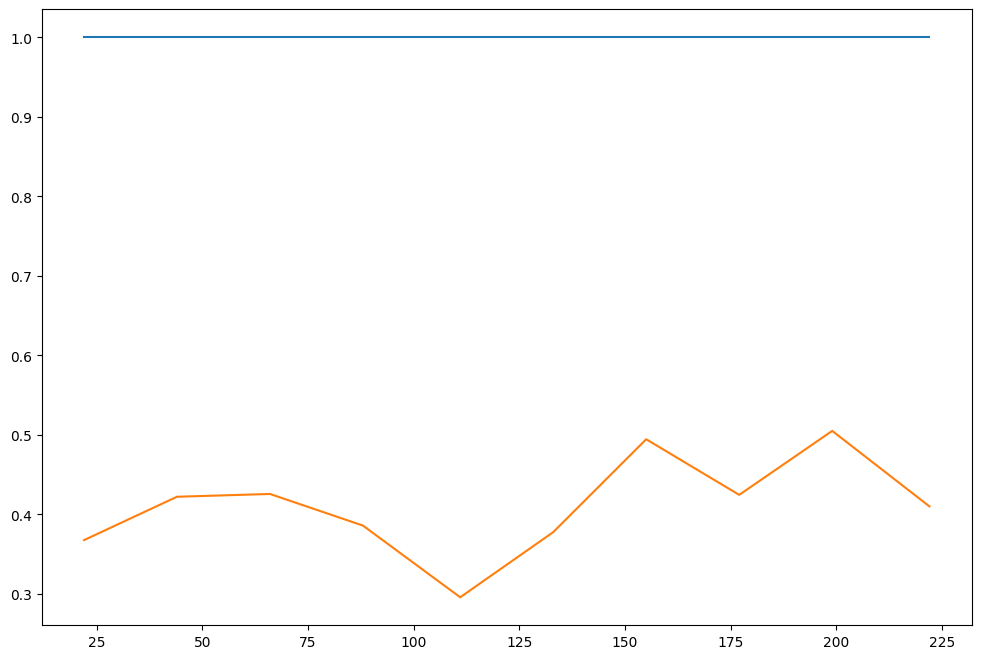

In [211]:
evaluate(model)

Le modèle n'arrive pas à prédire ce qui sont positifs
le modèle est bien entrainé sur notre model de train, mais n'arrive pas à bien prédire les données de test. => Nous avons donc un overfitting

In [212]:
# une solution serait de faire un fillNa : modifier le code de la fonction imputation.
"""
def imputation(df):
    df['is na'] = (df['Parainfluenza 3'].isna()) | (df['Leukocytes'].isna()) #
    df = df.fillna(-999)
    return df
"""

# Réponse : On a toujours rien, le model est beaucoup pire.
# le fillna même couplé avec le missing indicator ne fonctionne pas. donc on va laisser tomber, on va explorer une autre possibilté pour lutter contre l'underfitting

"\ndef imputation(df):\n    df['is na'] = (df['Parainfluenza 3'].isna()) | (df['Leukocytes'].isna()) #\n    df = df.fillna(-999)\n    return df\n"

**Autre possiblité pour lutter contre l'overfitting**

*Utilisation de l'attribut feature importances*

<Axes: >

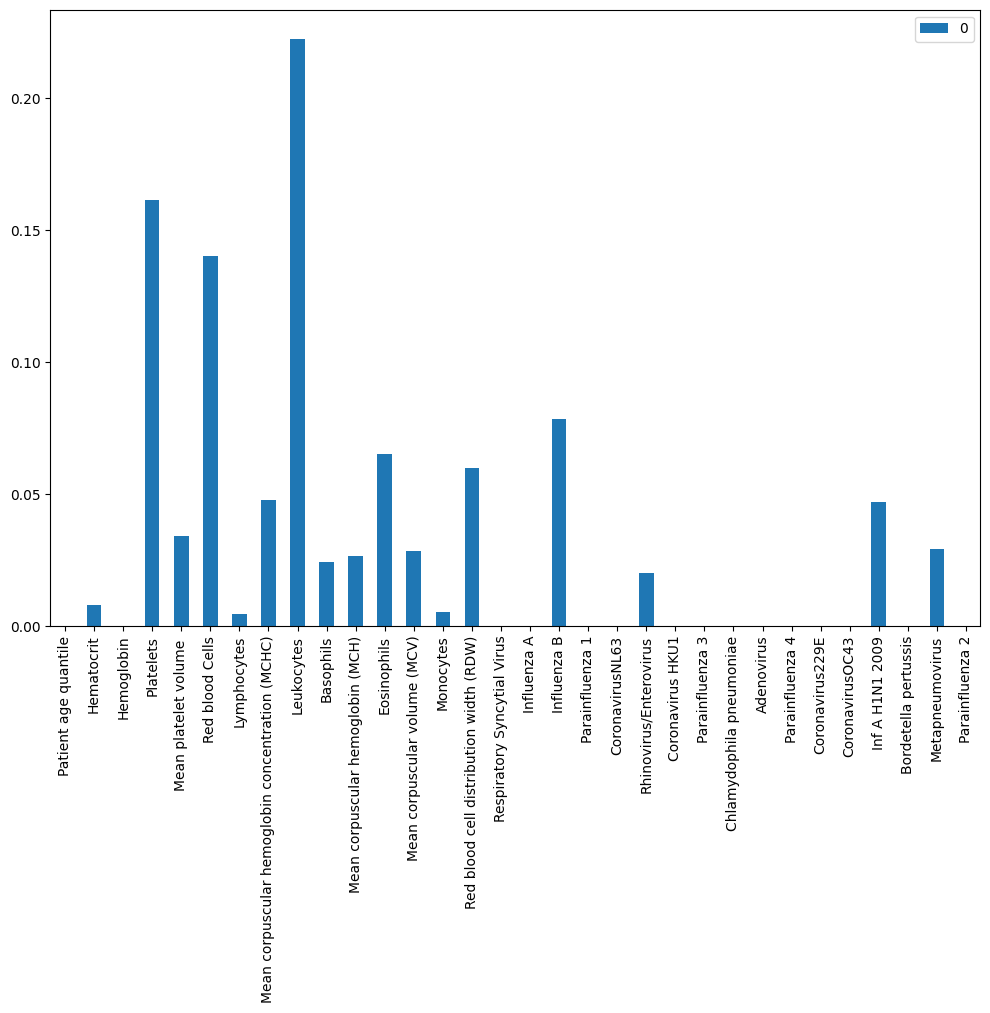

In [213]:
pd.DataFrame(model.feature_importances_, index=X_train.columns).plot.bar(figsize=(12,8))

On voit que les variables de types viral n'ont pas d'importances. On pourrait les supprimer

In [214]:
# On pourrait modifier la ligne suivante lors de la création des sous ensembles :
# df_covid19 = df_covid19[key_columns + blood_columns + viral_columns]
# par
# df_covid19 = df_covid19[key_columns + blood_columns ]

## Conclusion
#  - On a plus de données pour notre entrainement
#  - Mais, on n'a toujours pas bien entrainé notre model, il est encore en overfitting

## On a en tête un autre model de ML qui lutte contre l'overfitting : **la Randoom forest**

In [215]:
from sklearn.ensemble import RandomForestClassifier

In [216]:
#ON modifie notre classifier
model = RandomForestClassifier(random_state=0)

In [217]:
# On modifie la ligne suivante lors de la création des sous ensembles qui a été modifié :
# df_covid19 = df_covid19[key_columns + blood_columns + viral_columns]

In [218]:
# on ajoute une fonction
def feature_engineering(df):
    df['est malade'] = df[viral_columns].sum(axis=1) >=1
    df = df.drop(viral_columns, axis=1)
    return df

# la fonction est appelée dans la fonction preprocessing avant l'imputation
# Puis on relance l'entrainement ensuite la visualisation du scoring

In [219]:
def preprocessing(df):
    df = df.copy()
    df = encodage(df)
    df = feature_engineering(df)
    df = imputation(df)

    print(df['SARS-Cov-2 exam result'].value_counts())

    X = df.drop('SARS-Cov-2 exam result', axis=1)
    y = df['SARS-Cov-2 exam result']

    return X, pd.to_numeric(y)

In [220]:
X_train, y_train = preprocessing(trainset.copy())

SARS-Cov-2 exam result
0    422
1     65
Name: count, dtype: int64


In [221]:
X_test, y_test = preprocessing(testset.copy())

SARS-Cov-2 exam result
0    95
1    16
Name: count, dtype: int64


In [222]:
## Conclusion
#  - On a à nouveau plus de données pour notre entrainement et de test
#  - Mais, la performance ne s'améliore toujours pas, Mais on est sur une pente qui évolue

Lorsqu'on jette un coup d'œil sur le graphique de meilleur variable on se rend compte qu'il y a toujours plus de variables qui ne jouent pas grand role dans l'apprentissage du model

##### On pourrait utiliser le select key best avec un test de Anova

In [223]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif

In [228]:
# ON transforme notre model en model de pipeline:
model = make_pipeline(SelectKBest(f_classif, k=4),
                      RandomForestClassifier(random_state=0))
# on a testé une sélection de k = 10, ensuit 5, 2, enfin 4, avec k meilleurs features en test de Anova

F1 score: 0.5
[[90  5]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        95
           1       0.58      0.44      0.50        16

    accuracy                           0.87       111
   macro avg       0.75      0.69      0.71       111
weighted avg       0.86      0.87      0.87       111



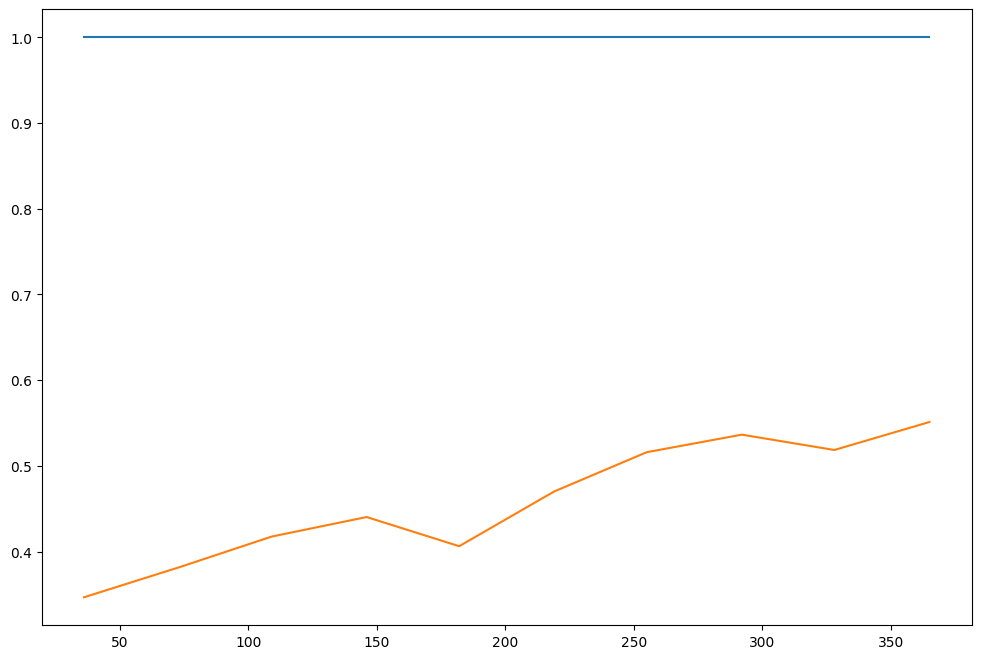

In [229]:
evaluate(model)

On obtient quelque chose qui n'est pas du tout mal

##### On pourrait être tenté de faire une polynomiale feature de degré 2

Qui va élever chaque variable au carré et aussi multiplier chaque variable avec ses différentes voisines.

In [230]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

In [231]:
model = make_pipeline(PolynomialFeatures(2), SelectKBest(f_classif, k=10), RandomForestClassifier(random_state=0))
# avec 10 meilleurs variables

C:\Program Files\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Program Files\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Program Files\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Program Files\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


F1 score: 0.4
[[91  4]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        95
           1       0.56      0.31      0.40        16

    accuracy                           0.86       111
   macro avg       0.72      0.64      0.66       111
weighted avg       0.84      0.86      0.85       111



C:\Program Files\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Program Files\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Program Files\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Program Files\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Program Files\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWa

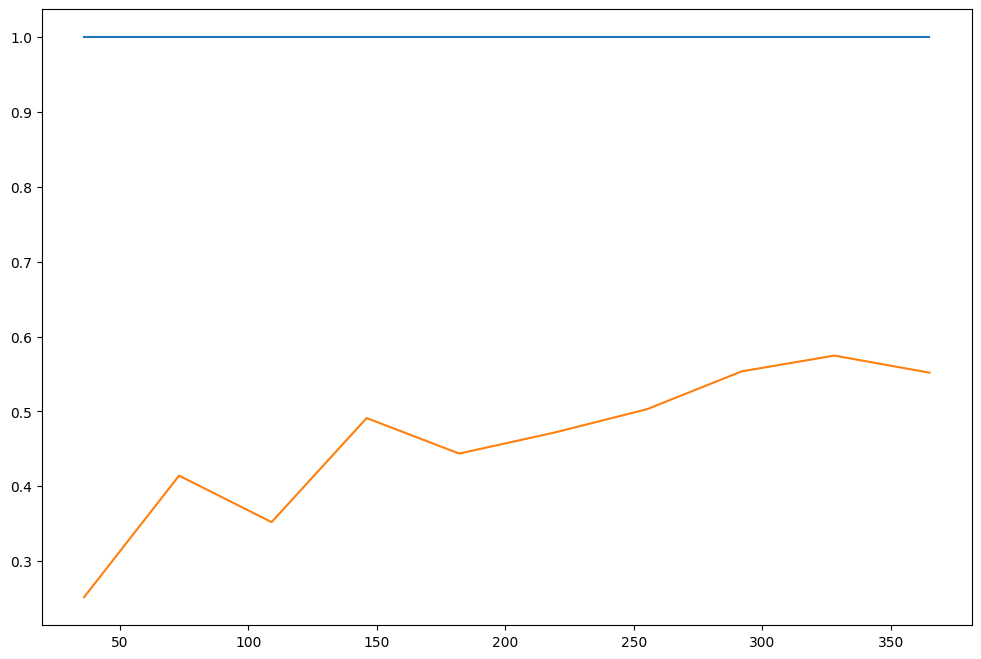

In [232]:
evaluate(model)

On obtient un résultat qui est encore mieux.

In [233]:
# Avec ceci, en le combinant avec un gridSearchCV on pourrait obtenir un bon résultat

# Save data: train and test

In [236]:
trainset = pd.concat([X_train, y_train], axis=1)

In [239]:
testset = pd.concat([X_test, y_test], axis=1)

In [240]:
import os
os.makedirs('data/data_after_preprocessing', exist_ok=True)

In [241]:
trainset.to_csv('data/data_after_preprocessing/trainset.csv', index=False)

In [242]:
testset.to_csv('data/data_after_preprocessing/testset.csv', index=False)